<a href="https://colab.research.google.com/github/econ105/AI/blob/main/predicting_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import os
import openpyxl

In [ ]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [ ]:
sp500.index = pd.to_datetime(sp500.index)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-12 00:00:00-04:00,5807.200195,5845.370117,5786.080078,5844.189941,6014580000,0.0,0.0
2025-05-13 00:00:00-04:00,5854.149902,5906.640137,5845.020020,5886.549805,5516290000,0.0,0.0
2025-05-14 00:00:00-04:00,5896.740234,5906.549805,5872.109863,5892.580078,5233450000,0.0,0.0


In [ ]:
df = pd.read_csv("sp500.csv")

In [ ]:
df.to_excel('sp500.xlsx', index=False)

In [ ]:
from google.colab import files

files.download('sp500.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='Date'>

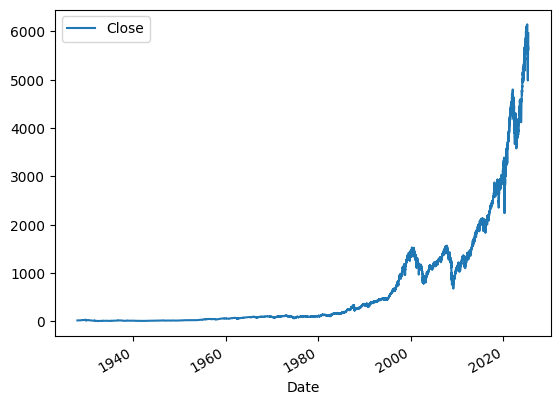

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5949367088607594

<Axes: xlabel='Date'>

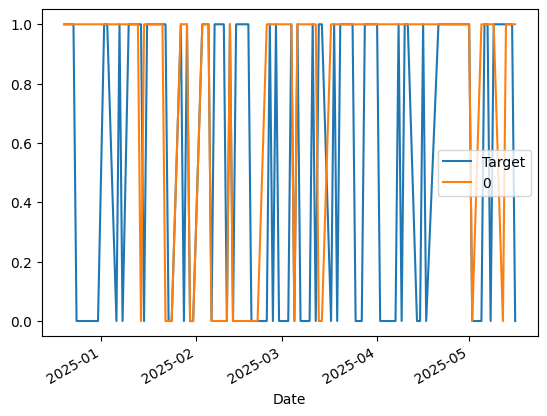

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3745
1,2665


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5305816135084428

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.536505
0,0.463495


In [ ]:
predictions

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0
...,...,...
2025-05-12 00:00:00-04:00,1,0
2025-05-13 00:00:00-04:00,1,0
2025-05-14 00:00:00-04:00,1,0


from matplotlib import pyplot as plt
predictions['Target'].plot(kind='hist', bins=20, title='Target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions['Predictions'].plot(kind='hist', bins=20, title='Predictions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions.plot(kind='scatter', x='Target', y='Predictions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
predictions['Target'].plot(kind='line', figsize=(8, 4), title='Target')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
predictions['Predictions'].plot(kind='line', figsize=(8, 4), title='Predictions')
plt.gca().spines[['top', 'right']].set_visible(False)